In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, roc_curve, auc

import pickle

In [18]:
data = pd.read_csv('final_data_cleaned.csv')

infection_rate = data['INFECTION RATE']

data = data.drop('INFECTION RATE', axis = 1)
data.insert(101, "INFECTION RATE", infection_rate)
pred_set = data.loc[data['INFECTION RATE'] == 0.0]

data = data.drop(pred_set.index)

In [31]:
data.shape

(2618, 102)

In [3]:
median = data["INFECTION RATE"].median()

In [4]:
def label_risk(num): 
    if num < median: 
        return -1 # low risk
    else:
        return 1 # high risk

In [5]:
data["risk"] = data["INFECTION RATE"].apply(label_risk)

In [30]:
data['INFECTION RATE'].describe()

count    2618.000000
mean        0.071938
std         0.183478
min         0.001578
25%         0.017626
50%         0.034648
75%         0.068314
max         6.022003
Name: INFECTION RATE, dtype: float64

In [16]:
X = data.iloc[:, 4:101] # no total population
X = X.drop("LAND AREA(SQMI)", axis = 1)
y = data["risk"]

pred_X = pred_set.iloc[:, 4:101] # no total population
pred_X = pred_X.drop("LAND AREA(SQMI)", axis = 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [8]:
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(recall_score(y_test, y_pred, average='binary'))

0.6181474480151229


In [9]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.001, 0.01, 0.1]
}
clf = GradientBoostingClassifier(random_state=0)
grid = GridSearchCV(
    clf,
    param_grid,
    scoring = 'recall',
    return_train_score = True
)
grid.fit(X_train, y_train)

df = pd.DataFrame(grid.cv_results_)
df['mean_test_score']
df['mean_train_score']
cols_to_keep = ["param_learning_rate", "param_max_depth","param_min_samples_split", "param_n_estimators",
                "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow = df_toshow.sort_values(by = ["mean_test_score"])
df_toshow.head()

,param_learning_rate,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,mean_train_score
15,0.001,5,6,100,0.456410,0.578846
12,0.001,5,4,100,0.456410,0.578846
9,0.001,5,2,100,0.457692,0.578846
0,0.001,3,2,100,0.464103,0.522756
3,0.001,3,4,100,0.464103,0.522756


In [10]:
df_toshow = df_toshow.sort_values(by = ["mean_test_score"], ascending = False)
df_toshow

,param_learning_rate,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,mean_train_score
55,0.100,3,2,300,0.646154,0.999038
61,0.100,3,6,300,0.643590,0.998397
63,0.100,5,2,100,0.642308,1.000000
68,0.100,5,4,500,0.642308,1.000000
67,0.100,5,4,300,0.641026,1.000000
...,...,...,...,...,...,...
0,0.001,3,2,100,0.464103,0.522756
6,0.001,3,6,100,0.464103,0.522756
9,0.001,5,2,100,0.457692,0.578846
12,0.001,5,4,100,0.456410,0.578846


In [11]:
best_params = df_toshow.head(1)

params = {
    'n_estimators': best_params['param_n_estimators'].item(), 
    'max_depth': best_params['param_max_depth'].item(), 
    'min_samples_split': best_params['param_min_samples_split'].item(),
    'learning_rate': best_params['param_learning_rate'].item(), 
}
print(params)

clf = GradientBoostingClassifier(random_state = 0, **params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(recall_score(y_test, y_pred, average='binary'))

{'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 2, 'learning_rate': 0.1}
0.6370510396975425


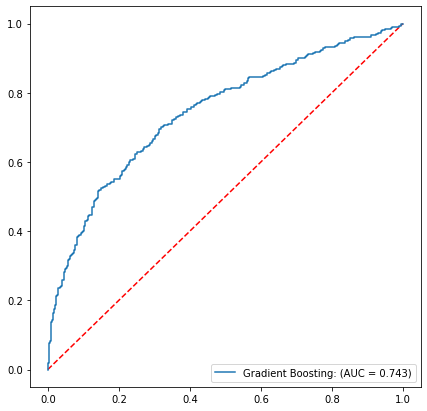

In [12]:
y_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr, tpr, label = 'Gradient Boosting: (AUC = %0.3f)' % roc_auc)
plt.legend(loc = 'lower right')

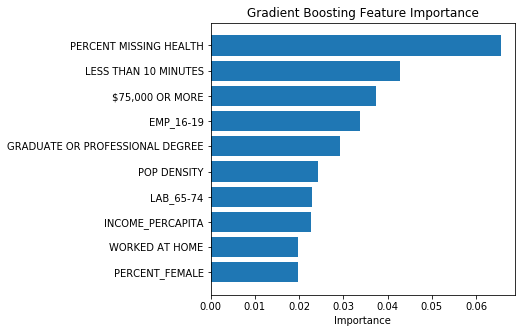

In [13]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10 = sorted_idx[-10:]
pos = np.arange(top_10.shape[0]) + .5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[top_10], align='center')
plt.yticks(pos, X.columns[top_10])
plt.xlabel('Importance')
plt.title('Gradient Boosting Feature Importance')
plt.show()

In [19]:
infection_rate_predictions = clf.predict(pred_X)
pred_set["RISK"] = infection_rate_predictions
pred_set

,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE,RISK
30,0500000US01061,Geneva County,Alabama,26491.0,6.3,5.3,5.4,5.8,7.7,6.4,...,0.0,55.233853,41.312144,46.098675,50.447322,26.865672,577.13,45.901270,0.0,1
67,0500000US02013,Aleutians East Borough,Alaska,3425.0,5.0,6.9,8.1,6.3,7.7,7.2,...,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,8496.37,0.403113,0.0,1
68,0500000US02016,Aleutians West Census Area,Alaska,5750.0,4.8,9.2,8.6,8.8,7.4,6.6,...,0.0,73.540479,45.684151,64.640821,54.583808,82.758621,8718.39,0.659525,0.0,1
71,0500000US02060,Bristol Bay Borough,Alaska,890.0,5.1,4.3,5.8,4.4,11.7,8.4,...,42.9,73.540479,45.684151,64.640821,54.583808,82.758621,644.05,1.381880,0.0,1
72,0500000US02068,Denali Borough,Alaska,2232.0,5.6,13.4,5.5,6.5,7.6,14.2,...,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,6379.26,0.349884,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,0500000US55123,Vernon County,Wisconsin,30516.0,6.6,4.7,4.6,5.0,8.0,7.5,...,1.3,59.444226,40.339494,38.914012,60.869708,25.000000,803.66,37.971281,0.0,-1
3117,0500000US55129,Washburn County,Wisconsin,15689.0,5.0,4.0,3.9,4.7,8.8,9.4,...,1.1,87.025355,38.863278,55.295402,70.593231,25.000000,822.91,19.065268,0.0,-1
3125,0500000US56003,Big Horn County,Wyoming,11901.0,7.0,4.5,5.0,5.6,6.2,7.4,...,2.7,87.025355,38.863278,55.295402,70.593231,56.521739,3144.78,3.784366,0.0,-1
3139,0500000US56031,Platte County,Wyoming,8673.0,5.7,4.9,4.3,5.4,6.4,9.3,...,0.0,87.025355,38.863278,55.295402,70.593231,56.521739,2083.22,4.163266,0.0,-1


In [22]:
pred_set_toshow = pred_set[['COUNTY','STATE','RISK']]
pred_set_toshow

,COUNTY,STATE,RISK
30,Geneva County,Alabama,1
67,Aleutians East Borough,Alaska,1
68,Aleutians West Census Area,Alaska,1
71,Bristol Bay Borough,Alaska,1
72,Denali Borough,Alaska,1
...,...,...,...
3114,Vernon County,Wisconsin,-1
3117,Washburn County,Wisconsin,-1
3125,Big Horn County,Wyoming,-1
3139,Platte County,Wyoming,-1


In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pred_set_toshow)

,COUNTY,STATE,RISK
30,Geneva County,Alabama,1
67,Aleutians East Borough,Alaska,1
68,Aleutians West Census Area,Alaska,1
71,Bristol Bay Borough,Alaska,1
72,Denali Borough,Alaska,1
73,Dillingham Census Area,Alaska,-1
75,Haines Borough,Alaska,1
76,Hoonah-Angoon Census Area,Alaska,1
80,Kodiak Island Borough,Alaska,-1
81,Kusilvak Census Area,Alaska,-1


In [26]:
#y_proba_pd = pd.DataFrame(y_proba)

In [27]:
#y_proba_pd.to_csv(r'gBoosting_y_proba.csv', index = True)

In [29]:
pred_set['RISK'].value_counts(ascending=True)

 1    230
-1    299
Name: RISK, dtype: int64